# Economic Data Analysis with Fred & Pandas


In [1]:
!pip install fredapi > /dev/null

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = 'cea00c39d59d1a070a2daad7a40e28bb'

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()
fred_key = secrets.get_secret('fred-api')

# 1. Create The Fred Object

In [3]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data!

In [4]:
sp_search = fred.search('S&P', order_by='popularity')

In [5]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2022-10-20,2022-10-20,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2022-10-19,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-20 08:47:09-05:00,95,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2022-10-20,2022-10-20,S&P/Case-Shiller U.S. National Home Price Index,1987-01-01,2022-07-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2022-09-27 15:48:02-05:00,90,"For more information regarding the index, plea..."
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2022-10-20,2022-10-20,ICE BofA US High Yield Index Effective Yield,1996-12-31,2022-10-19,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2022-10-20 08:47:13-05:00,86,This data represents the effective yield of th...
SP500,SP500,2022-10-20,2022-10-20,S&P 500,2012-10-22,2022-10-19,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2022-10-19 19:10:49-05:00,84,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2022-10-20,2022-10-20,Real Median Household Income in the United States,1984-01-01,2021-01-01,Annual,A,2021 CPI-U-RS Adjusted Dollars,2021 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2022-09-13 13:48:01-05:00,82,Household data are collected as of March. As ...


# 3. Pull Raw Data & Plot

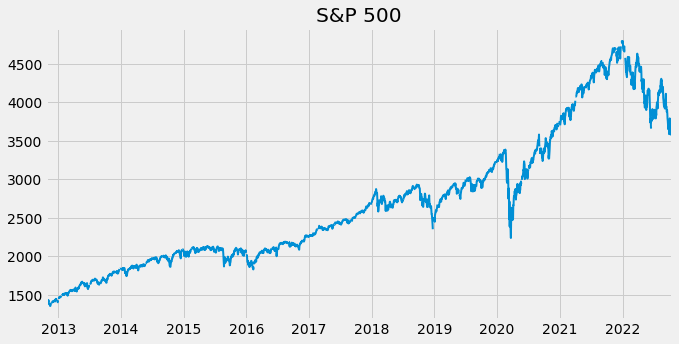

In [6]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

# 4. Pull and Join Multiple Data Series

In [7]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [8]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [9]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [10]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [11]:
# Plot States Unemployment Rate
px.line(uemp_states)